## TASK 3

### 3.1

Use an LLM to write a PyTorch program to be handed in the file feedforwardAssignment.ipynb. The program should contain a data generation class, a model class implementing for example the network listed above, a training loop (with mini-batch learning using the PyTorch DataLoader method and the Adam optimizer), visualization to make plots like Figure 1 for both the training and a validation set. When making programs with an LLM, it works well to give a short description of the overall task and then in the back and forth manner break the task into subtasks that each can be validated independently.

(a) There are two versions of the binary cross entropy loss function in PyTorch. What is the difference, and which one should you use?

The two versions are torch.nn.BCELoss and torch.nn.BCEWithLogitsLoss. BCELoss expects the input to be probabilities (values between 0 and 1). This means you must apply a Sigmoid activation function ($\sigma(x)$) as the final layer of your network before passing the output to the loss function. Whereas BCEWithLogitsLoss expects the input to be raw "logits" (unbounded real numbers). It applies the Sigmoid activation and the Cross Entropy calculation in a single, numerically stable step. 

We will use BCEWithLogitsLoss due to numerical stability, where combining the sigmoid and loss layer prevents numerical issues (like overflow/underflow) that can happen with log-sum-exp calculations. And because the assignment says the following: "The activation function of the output unit $\sigma()$ is built into the binary cross entropy loss function.", which describes BCEWithLogitsLoss. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from matplotlib import animation
from IPython.display import HTML

In [2]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 0 – Reproducibility Setup
# Theory used: Fitting NNs Tricks of the Trade MLOps.pdf
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
def set_seed(seed=42):

    """
    Goal: Fix the random number generators to ensure results are the same 
    every time you run the code.
    
    Theory: Deep learning involves many stochastic (random) processes:
    1. Initializing weights (random numbers from a distribution) 
    2. Shuffling data in mini-batches 
    3. Generating noise for the dataset
    Without a fixed seed, optimization paths differ, making debugging hard.
    """
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# Call this immediately to lock in randomness
set_seed(42)

Random seed set to 42


In [3]:
#–––––––––––––––––––––––––––––––––––––––––––
# First step – Data Generation Class
# Theory used: DL_FFNN.pdf 
#–––––––––––––––––––––––––––––––––––––––––––

class NoisyXORDataset(Dataset):

    """
    Goal: Create a synthetic dataset that represents the non-linear XOR problem.
    
    Theory: 
    The XOR problem (exclusive OR) is a classic example of a problem that 
    cannot be solved by a linear classifier (a single straight line). 
    It requires a non-linear model (like a neural network with hidden layers) 
    to separate the classes. 
    
    'DL_FFNN.pdf': "How a feed-forward neural network learns XOR".
    """

    def __init__(self, n_samples=1000, std_dev=0.1):
        self.n_samples = n_samples
        self.std_dev = std_dev
        self.data, self.labels = self._generate_data()

    def _generate_data(self):
        #Goal: Create 4 distinct clusters centered at (0,0), (0,1), (1,0), (1,1)
        #These represent the binary inputs for XOR.
        centers = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
        
        #Goal: Assign labels based on XOR logic:
        #0 XOR 0 = 0 (Class 0)
        #0 XOR 1 = 1 (Class 1)
        #1 XOR 0 = 1 (Class 1)
        #1 XOR 1 = 0 (Class 0)
        center_labels = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
        
        #Randomly assign each sample to one of the 4 centers
        indices = torch.randint(0, 4, (self.n_samples,))
        selected_centers = centers[indices]
        selected_labels = center_labels[indices]
        
        #Goal: Add Gaussian noise to make it a "Noisy" XOR problem.
        #This spreads the points out, making it a statistical learning problem rather than just logic.
        #Theory: We assume the data comes from a distribution p(x|t).
        noise = torch.randn(self.n_samples, 2) * self.std_dev
        data = selected_centers + noise
        
        return data, selected_labels

    def __len__(self):
        #Required by PyTorch Dataset to know how many items we have
        return self.n_samples

    def __getitem__(self, idx):
        #Required by PyTorch DataLoader to pull specific samples
        return self.data[idx], self.labels[idx]

In [4]:
#––––––––––––––––––––––––––––––––––––––––––––
# Step 2 – Model Class (Feed-Forward Network)
# Theory used: DL_FFNN.pdf 
#––––––––––––––––––––––––––––––––––––––––––––

class SimpleFeedForward(nn.Module):

    """
    Goal: Define the architecture of the neural network.
    
    Architecture: Input(2) -> Hidden(3) -> Activation(Tanh) -> Output(1)
    
    Theory:
    - Hidden Units: Allow the network to learn non-linear transformations of the input space.
      (See 'DL_FFNN.pdf' slide 11 'Example Network').
    - Tanh Activation: Introduces non-linearity. Without this, the network would just be 
      a big linear regression model, incapable of solving XOR.
      (See 'DL_FFNN.pdf' slide 6 regarding Tanh/Sigmoid/ReLU).
    """

    def __init__(self):
        super(SimpleFeedForward, self).__init__()
        self.model = nn.Sequential(
            #Layer 1: Linear transformation from 2 inputs to 3 hidden neurons
            #We use 3 hidden units to allow enough "capacity" to fold the space effectively for XOR.
            nn.Linear(in_features=2, out_features=3, bias=True),
            
            #Activation: Tanh (Hyperbolic Tangent)
            #Maps values to range [-1, 1]. Often used in older architectures or simple problems.
            nn.Tanh(),
            
            #Layer 2: Linear transformation from 3 hidden neurons to 1 output
            nn.Linear(in_features=3, out_features=1, bias=True),
            
            #Final Output: Identity (Linear)
            #Goal: We output raw scores ("logits") ranging from -infinity to +infinity.
            #We do NOT use Sigmoid here because we will use BCEWithLogitsLoss later.
            #This improves numerical stability.
            nn.Identity() 
        )

    def forward(self, x):
        #Defines the forward pass: x -> Linear -> Tanh -> Linear -> logits
        return self.model(x)


In [5]:

#––––––––––––––––––––––––––––––––––––––––––––
#          Visualization Function
#––––––––––––––––––––––––––––––––––––––––––––
def plot_decision_boundary(model, dataset, title="Decision Boundary"):
    """
    Goal: Visualize what the model has learned.
    We create a grid covering the input space, ask the model to predict the class 
    for every point in that grid, and color it. This shows the "Decision Boundary".
    """
    #Create a meshgrid covering the data range
    #We use .item() to convert the 0-d tensors to simple python floats
    x_min = dataset.data[:, 0].min().item() - 0.5
    x_max = dataset.data[:, 0].max().item() + 0.5
    y_min = dataset.data[:, 1].min().item() - 0.5
    y_max = dataset.data[:, 1].max().item() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    #Flatten grid and convert to Tensor for the model
    grid_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    
    #Get predictions
    model.eval() #Switch to evaluation mode (turns off dropout/batchnorm if present)
    with torch.no_grad(): #Theory: We don't need gradients for plotting, saves memory
        logits = model(grid_tensor)
        probs = torch.sigmoid(logits) #Theory: Apply Sigmoid manually here to get probability (0-1)
        preds = probs.reshape(xx.shape)
        
    #Plot contours
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.8, cmap=plt.cm.RdBu)
    
    #Scatter plot actual data points on top
    X = dataset.data.numpy()
    y = dataset.labels.numpy().flatten()
    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0 (Blue)', edgecolors='k')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='orange', label='Class 1 (Orange)', edgecolors='k')
    
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()



In [6]:
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 4 – Training Setup and Hyperparameters
# Theory used: Fitting NNs Tricks of the Trade MLOps.pdf
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

#Hyperparameters
BATCH_SIZE = 32        #Theory: Mini-batch training (Tricks of Trade slide 16)
LEARNING_RATE = 0.1    #Theory: Step size for Gradient Descent (DLBackprop slide 13)
EPOCHS = 100           #How many times to iterate over the full dataset
STD_DEV = 0.1          #The 's' parameter in your assignment formula

#Setup Data
train_dataset = NoisyXORDataset(n_samples=1000, std_dev=STD_DEV)
val_dataset = NoisyXORDataset(n_samples=200, std_dev=STD_DEV)

#Theory: DataLoader handles shuffling and batching efficiently
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#Initialize Model
model = SimpleFeedForward()

#Loss Function
#Theory: 'BCEWithLogitsLoss' combines Sigmoid layer + BCELoss in one step.
#This prevents numerical underflow/overflow (log(0) issues).
#'DLBackpropagation.pdf' slide 12 on Cross-Entropy.
criterion = nn.BCEWithLogitsLoss() 

#Optimizer
#Theory: Adam (Adaptive Moment Estimation) converges faster than standard SGD.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 5 – Training Loop
# Theory used: DLBackpropagation.pdf 
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    #Training Phase
    model.train() #Set mode to training (enables gradients)
    epoch_loss = 0
    
    for inputs, targets in train_loader:
        #1. Zero Gradients: Clear old gradients from previous step
        #Theory: PyTorch accumulates gradients by default, so we must zero them.
        optimizer.zero_grad()
        
        #2. Forward Pass: Compute predictions
        #Theory: Pass data x through the network to get y_pred
        outputs = model(inputs)
        
        #3. Calculate Loss: How wrong was the model?
        #Theory: Compute Binary Cross Entropy between logits and targets
        loss = criterion(outputs, targets)
        
        #4. Backward Pass (Backpropagation): Compute gradient of loss w.r.t weights
        #Theory: Chain rule! dLoss/dWeights. See 'DLBackpropagation.pdf' slides 137+
        loss.backward()
        
        #5. Optimization Step: Update weights
        #Theory: w_new = w_old - learning_rate * gradient
        optimizer.step()
        
        epoch_loss += loss.item()
    
    #Calculate average loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    #Validation Phase
    #Goal: Check performance on unseen data to monitor for overfitting.
    #Theory: 'Fitting NNs Tricks of the Trade MLOps.pdf' slide 38 (Learning curves)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Starting training...
Epoch [10/100], Train Loss: 0.0047, Val Loss: 0.0040
Epoch [20/100], Train Loss: 0.0015, Val Loss: 0.0013
Epoch [30/100], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [40/100], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [50/100], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [60/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [70/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [100/100], Train Loss: 0.0001, Val Loss: 0.0001


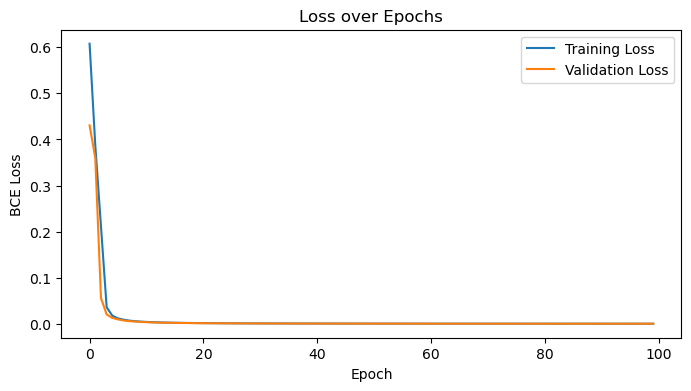

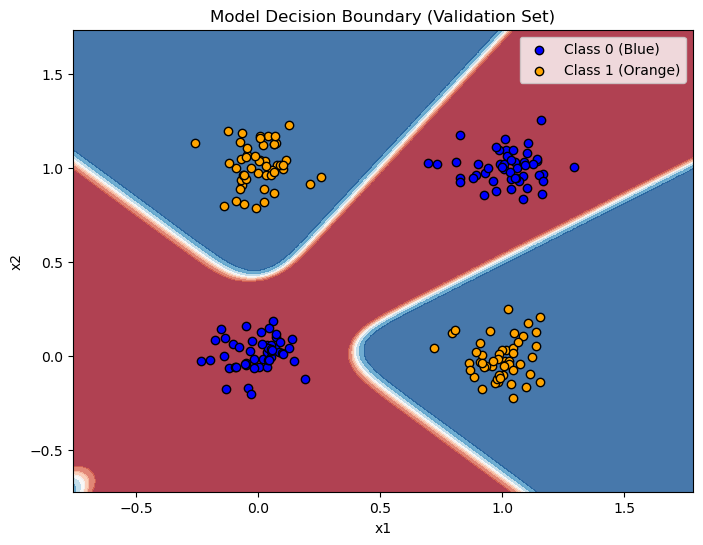

In [8]:
#––––––––––––––––––––––––––––––––––––––––––––
#            Final Visualization
#––––––––––––––––––––––––––––––––––––––––––––

#Plot Learning Curves
#Theory: We want to see Training and Validation loss decreasing together.
#If Training goes down but Validation goes up, we are Overfitting.
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

#Plot Decision Boundary on Validation Set
plot_decision_boundary(model, val_dataset, title="Model Decision Boundary (Validation Set)")

### Little conclusion for 3.1

Based on the results, we can conclude that the feed-forward neural network successfully solved the non-linear Noisy-XOR classification task, achieving near-zero loss on both the training and validation datasets. The decision boundary visualization confirms that the model, utilizing a single hidden layer with Tanh activation, effectively learned the necessary non-linear transformations to isolate the opposing classes, a task that would be impossible for a simple linear classifier. This validates the theoretical premise that hidden units allow the network to fold the input space into a representation that is linearly separable at the output layer, and the consistent drop in validation loss indicates the model generalized well to unseen data without overfitting.

### 3.2

Update feedforwardAssignment.ipynb such that it tests a range of networks for how well they can classify the noisy-xor data source. As a minimum try repeatedly all combinations of 0 . . . 3 hidden layers with widths 1 . . . 3. For each combination of depth and width, calculate the mean and standard deviation of the resulting loss function on a new data set.

In [9]:
#––––––––––––––––––––––––––––––––––––––––––––
# Step 0 – Reproducibility Setup
#––––––––––––––––––––––––––––––––––––––––––––
def set_seed(seed=42):

    """
    Goal: Ensure the entire experiment is reproducible.
    Note: We set the seed ONCE here. We do NOT reset it inside the training loop
    because we WANT different random weights for each repetition to calculate 
    standard deviation (variance).
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

Random seed set to 42


In [10]:
#–––––––––––––––––––––––––––––––––––––––––––––
# First step – Data Generation (Same as before)
#–––––––––––––––––––––––––––––––––––––––––––––
class NoisyXORDataset(Dataset):
    def __init__(self, n_samples=1000, std_dev=0.1):
        self.n_samples = n_samples
        self.std_dev = std_dev
        self.data, self.labels = self._generate_data()

    def _generate_data(self):
        centers = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
        center_labels = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
        indices = torch.randint(0, 4, (self.n_samples,))
        noise = torch.randn(self.n_samples, 2) * self.std_dev
        data = centers[indices] + noise
        return data, center_labels[indices]

    def __len__(self): return self.n_samples
    def __getitem__(self, idx): return self.data[idx], self.labels[idx]

In [11]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 2 – Dynamic Model Class
# Theory used: "Deep versus wide networks" (Assignment text)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

class DynamicFeedForward(nn.Module):

    """
    Goal: Create a flexible neural network where we can control:
    1. 'depth': Number of hidden layers.
    2. 'width': Number of neurons per hidden layer.
    
    Theory:
    - Depth 0: Represents a Linear Classifier (Logistic Regression). It cannot solve XOR.
    - Depth > 0: Introduces hidden representations to warp the input space.
    - Width: Determines the capacity of each layer. XOR theoretically needs a width of at least 2.
    """

    def __init__(self, input_dim=2, depth=1, width=3):
        super(DynamicFeedForward, self).__init__()
        layers = []
        
        current_dim = input_dim
        
        #Hidden Layers
        for _ in range(depth):
            layers.append(nn.Linear(current_dim, width))
            layers.append(nn.Tanh()) # Activation (Non-linearity)
            current_dim = width
            
        #Output Layer
        #Maps from the last hidden layer (or input if depth=0) to 1 output node
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Identity()) #Output raw logits
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 3 – Experiment & Evaluation Functions
# Theory used: Fitting NNs (Model Selection & Statistics)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

def train_and_evaluate(depth, width, train_loader, test_loader, epochs=100):
    """
    Goal: Train a SINGLE instance of a specific network configuration and 
    return its final test loss.
    """
    #Initialize model with specific depth/width
    model = DynamicFeedForward(depth=depth, width=width)
    
    #Standard Training Setup
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01) #slightly lower LR for stability
    
    #Training Loop
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
    #Evaluation on "New Data Set" (Test Set)
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()
            
    avg_test_loss = total_test_loss / len(test_loader)
    return avg_test_loss

def run_experiment():
    """
    Goal: Systematically test range of Depth (0..3) and Width (1..3).
    Calculate Mean and Std Dev to see which architecture is most reliable.
    """
    
    #Prepare Data, we use a fixed Training set and a fixed Test ("New") set for fair comparison.
    train_data = NoisyXORDataset(n_samples=1000, std_dev=0.1)
    test_data = NoisyXORDataset(n_samples=500, std_dev=0.1) # "New data set"
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    #Define Search Space
    depths = [0, 1, 2, 3]
    widths = [1, 2, 3]
    repeats = 5  #How many times to retrain each config to get std dev
    
    results = {}
    
    print(f"{'Depth':<6} | {'Width':<6} | {'Mean Loss':<10} | {'Std Dev':<10}")
    print("-" * 40)
    
    #Nested Loops for Grid Search
    for d in depths:
        for w in widths:
            #For Depth 0, width is irrelevant (it's just Input->Output), but we run the loop to keep structure simple or skip duplicates.
            if d == 0 and w > 1: 
                continue 
                
            losses = []
            
            #Repeatedly train to measure stability (variance)
            for i in range(repeats):
                final_loss = train_and_evaluate(d, w, train_loader, test_loader)
                losses.append(final_loss)
            
            mean_loss = np.mean(losses)
            std_loss = np.std(losses)
            
            results[(d, w)] = (mean_loss, std_loss)
            
            print(f"{d:<6} | {w:<6} | {mean_loss:.4f}     | {std_loss:.4f}")

    return results

In [13]:
#––––––––––––––––––––––––––––––––––––––––––––
#                 Execution
#––––––––––––––––––––––––––––––––––––––––––––

experiment_results = run_experiment()

Depth  | Width  | Mean Loss  | Std Dev   
----------------------------------------
0      | 1      | 0.6975     | 0.0011
1      | 1      | 0.4887     | 0.0131
1      | 2      | 0.1360     | 0.1625
1      | 3      | 0.0763     | 0.1491
2      | 1      | 0.4945     | 0.0197
2      | 2      | 0.1578     | 0.1969
2      | 3      | 0.0004     | 0.0003
3      | 1      | 0.4665     | 0.0121
3      | 2      | 0.0924     | 0.1834
3      | 3      | 0.0002     | 0.0001


### Little conclusion for 3.2

The investigation into network architecture reveals that the noisy-XOR problem requires a minimum level of non-linear capacity to be solved effectively. The linear baseline (Depth 0) failed completely with a mean loss of 0.6975, equivalent to random guessing, confirming that a single hyperplane cannot separate the XOR clusters. Furthermore, networks with a width of only one neuron consistently underperformed regardless of depth, acting as a bottleneck that prevented the necessary transformation of the input space. Significant improvements were only observed once the network width was increased to at least two neurons. The results demonstrate a clear trade-off between capacity and stability; while deeper and wider networks (e.g., Depth 2 or 3 with Width 3) achieved near-perfect classification with negligible loss (≈0.0002), intermediate configurations like Depth 3/Width 2 exhibited high variance (std dev 0.1834), indicating a sensitivity to random initialization where the model is prone to getting stuck in poor local minima. Therefore, a robust solution for this task requires a network with at least one hidden layer and a width greater than two to ensure both accuracy and reliable convergence.


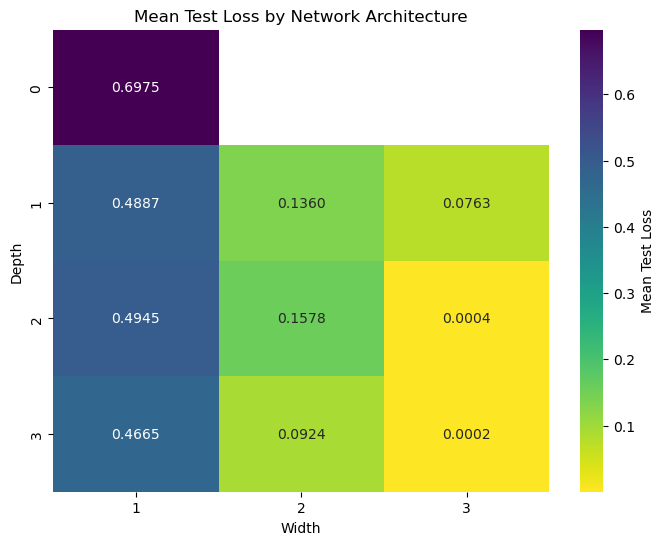

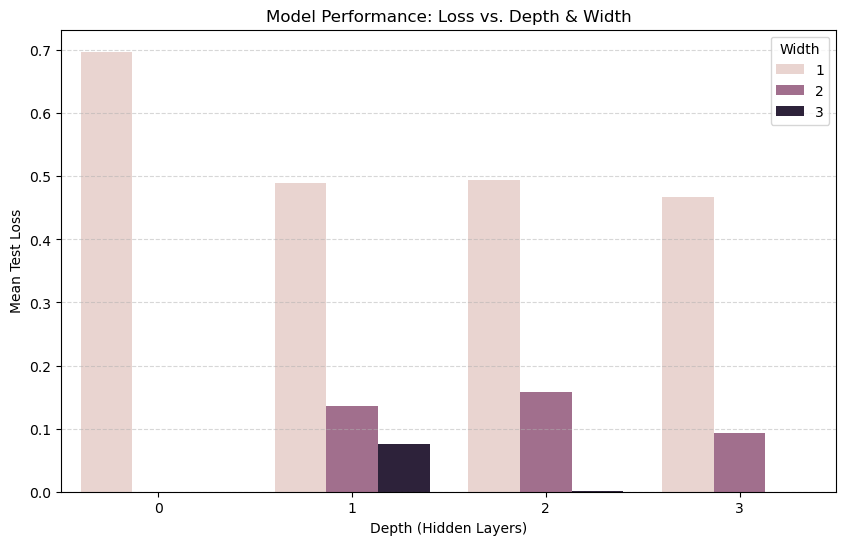

In [14]:
#––––––––––––––––––––––––––––––––––––––––––––
#       Visualisation of outcome
#––––––––––––––––––––––––––––––––––––––––––––

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Data from the results
data = [
    {'Depth': 0, 'Width': 1, 'Mean Loss': 0.6975, 'Std Dev': 0.0011},
    {'Depth': 1, 'Width': 1, 'Mean Loss': 0.4887, 'Std Dev': 0.0131},
    {'Depth': 1, 'Width': 2, 'Mean Loss': 0.1360, 'Std Dev': 0.1625},
    {'Depth': 1, 'Width': 3, 'Mean Loss': 0.0763, 'Std Dev': 0.1491},
    {'Depth': 2, 'Width': 1, 'Mean Loss': 0.4945, 'Std Dev': 0.0197},
    {'Depth': 2, 'Width': 2, 'Mean Loss': 0.1578, 'Std Dev': 0.1969},
    {'Depth': 2, 'Width': 3, 'Mean Loss': 0.0004, 'Std Dev': 0.0003},
    {'Depth': 3, 'Width': 1, 'Mean Loss': 0.4665, 'Std Dev': 0.0121},
    {'Depth': 3, 'Width': 2, 'Mean Loss': 0.0924, 'Std Dev': 0.1834},
    {'Depth': 3, 'Width': 3, 'Mean Loss': 0.0002, 'Std Dev': 0.0001}
]
df = pd.DataFrame(data)

#Heatmap
heatmap_data = df.pivot(index="Depth", columns="Width", values="Mean Loss")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis_r", cbar_kws={'label': 'Mean Test Loss'})
plt.title("Mean Test Loss by Network Architecture")
plt.show()

#Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Depth", y="Mean Loss", hue="Width", data=df, capsize=.1)
plt.title("Model Performance: Loss vs. Depth & Width")
plt.ylabel("Mean Test Loss")
plt.xlabel("Depth (Hidden Layers)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 3.3

Give a brief interpretation of the effect of changing the depth and width on the quality of classification in the above experiment. Calculate how many parameters each of the networks tested above has. Identify the training parameters used, and describe how changing them, may influence your conclusions on the quality of the classification.

Brief interpretation:

The experiment demonstrates that width is the primary bottleneck for classification quality on the Noisy-XOR problem, while depth acts as a stabilizer once sufficient width is achieved. 

For width effect, networks with a width of 1 neuron consistently failed (loss $\approx 0.49$), regardless of depth. This confirms the theoretical limitation that a single neuron cannot create the non-linear decision boundary required to separate the XOR clusters. A width of at least 2 is a strict requirement to fold the input space effectively.

For depth effect, then increasing depth generally improved convergence stability, but only when the width was sufficient (width $\ge 2$). While shallow networks (Depth 1) with sufficient width could solve the problem, they had higher variance (std dev $\approx 0.15-0.16$). Deeper networks (Depth 2 or 3) combined with width 3 achieved the lowest loss ($\approx 0.0002$) and the highest reliability (lowest standard deviation), suggesting that the extra layers help the optimizer navigate the loss landscape more consistently.

Parameter calculations:

Formulas: Depth 0 (Linear): $(2 \text{ inputs} \times 1 \text{ output}) + 1 \text{ bias} = \mathbf{3}$ and Depth > 0: Input Layer: $(2 \times W) + W$, Hidden Layers: $(d-1) \times [(W \times W) + W]$ and Output Layer: $(W \times 1) + 1$

The complexity of each network configuration was quantified by calculating the total number of trainable parameters (weights and biases). The linear baseline (Depth 0), consisting of a single layer connecting 2 inputs to 1 output, has the fewest parameters at just 3 ($2\times1$ weight + 1 bias). For networks with hidden layers, the parameter count grows with both depth and width according to the connections between layers. Shallow networks (Depth 1) remain relatively small, ranging from 5 parameters for Width 1 to 13 parameters for Width 3. As depth increases, the parameter count rises significantly; for instance, the Depth 2/Width 3 configuration contains 25 parameters ($9$ input-to-hidden, $12$ hidden-to-hidden, and $4$ hidden-to-output). The largest network tested, Depth 3 with Width 3, contains a total of 37 parameters, reflecting its increased capacity to model complex non-linear relationships compared to the simpler architectures.

Training parameter and influence (what happens if we change them) :

The networks were trained using the Adam optimizer with a learning rate of 0.01, a batch size of 32, and a duration of 100 epochs, utilizing PyTorch's default Kaiming Uniform initialization for weights. These specific settings played a significant role in the observed results; for instance, increasing the learning rate could have destabilized the convergence of smaller networks (e.g., Width 2), making them appear less effective than they are, while decreasing the learning rate would have required a corresponding increase in epochs to avoid underfitting, particularly in deeper networks that require more steps to propagate gradients effectively. Similarly, reducing the number of epochs below 100 would likely have prevented the deeper models (Depth 3) from converging, leading to the incorrect conclusion that added depth hurts performance. The initialization strategy was also critical; a poor choice, such as zero-initialization, would have prevented learning entirely due to symmetry breaking issues, whereas initialization with too high a variance could have caused exploding or vanishing gradients in the deeper architectures. Finally, increasing the batch size significantly might have smoothed the gradient estimates but could also have increased the likelihood of the model getting stuck in saddle points—a common issue in XOR problems—potentially inflating the variance observed in the intermediate configurations.

### 3.4

The file XOR_NNsandbox.ipynb available on Absalon visualizes the decision boundaries of the minimal XOR network with one hidden layer and two hidden units. Train your network with this architecture (still using tanh hidden activation functions), save weights during training and make a movie that show how the three decision boundaries evolve during training. Include this code in feedforwardAssignment.ipynb. Include a few snapshots from training in your report. It is encouraged to use an LLM and code from XOR_NNsandbox.ipynb to answer this question.

In [15]:
#––––––––––––––––––––––––––––––––––––––––––––––
# First step – Minimal XOR Model Class
# Theory used: DL_FFNN.pdf
#––––––––––––––––––––––––––––––––––––––––––––––
class MinimalXOR(nn.Module):

    """
    Goal: Define the smallest possible neural network architecture capable of solving the XOR problem.
    
    Theory:
    - Capacity: According to 'DL_FFNN.pdf' ("How a feed-forward neural network learns XOR"), 
      a two-layer network with exactly **two hidden units** is sufficient to solve XOR.
    - Mechanism: The two hidden units learn to act as linear separators for different parts of the 
      input space (e.g., one separates the top-left, the other the bottom-right). The output unit 
      then combines these features linearly.
    - Activation: We use Tanh (Slide 6) to introduce the necessary non-linearity. Without it, 
      the two linear layers would collapse into one, making the problem unsolvable.
    """

    def __init__(self):
        super(MinimalXOR, self).__init__()
        #Layer 1: 2 Inputs -> 2 Hidden Units (The "Bottleneck")
        self.hidden = nn.Linear(2, 2) 
        #Activation function
        self.activation = nn.Tanh()
        #Layer 2: 2 Hidden Units -> 1 Output Unit
        self.output = nn.Linear(2, 1)
        #Identity activation for raw logits (compatible with BCEWithLogitsLoss)
        self.identity = nn.Identity()

    def forward(self, x):
        #Defines the forward pass: Input -> Hidden Layer -> Activation -> Output Layer
        h = self.activation(self.hidden(x))
        out = self.identity(self.output(h))
        return out

In [16]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 2 – Training with History Capture
# Theory used: DLBackpropagation.pdf 
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
def train_and_capture(model, train_loader, epochs=200):
    """
    Goal: Train the model while saving a "snapshot" of its weights at every single epoch.
    This allows us to visualize the *dynamics* of learning—how the decision boundaries 
    move and rotate over time—rather than just the final result.
    """
    criterion = nn.BCEWithLogitsLoss()
    
    #Theory: We use a slightly higher learning rate (0.05) to ensure the movement of boundaries is visible and dramatic enough for the animation.
    optimizer = optim.Adam(model.parameters(), lr=0.05) 
    
    history = [] #List to store the state of the model at each step

    model.train()
    for epoch in range(epochs):
        #SNAPSHOT STEP: Save a deep copy of the current weights and biases.
        #We must use deepcopy, otherwise 'history' would just point to the final weights 200 times.
        history.append(copy.deepcopy(model.state_dict()))
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()               #Clear previous gradients
            outputs = model(inputs)             #Forward pass
            loss = criterion(outputs, targets)  #Calculate error
            loss.backward()                     #Backpropagation (Compute gradients)
            optimizer.step()                    #Update weights (Gradient Descent)
            
    return history

#Setup and Execution
#We use the same dataset class from previous tasks
set_seed(42) 
train_dataset = NoisyXORDataset(n_samples=1000, std_dev=0.1)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#Initialize the specific "Minimal" architecture
model_vis = MinimalXOR()

#Train and get the history of weights
print("Training model and capturing history...")
history = train_and_capture(model_vis, train_loader, epochs=200)
print(f"Captured {len(history)} training states.")

Random seed set to 42
Training model and capturing history...
Captured 200 training states.


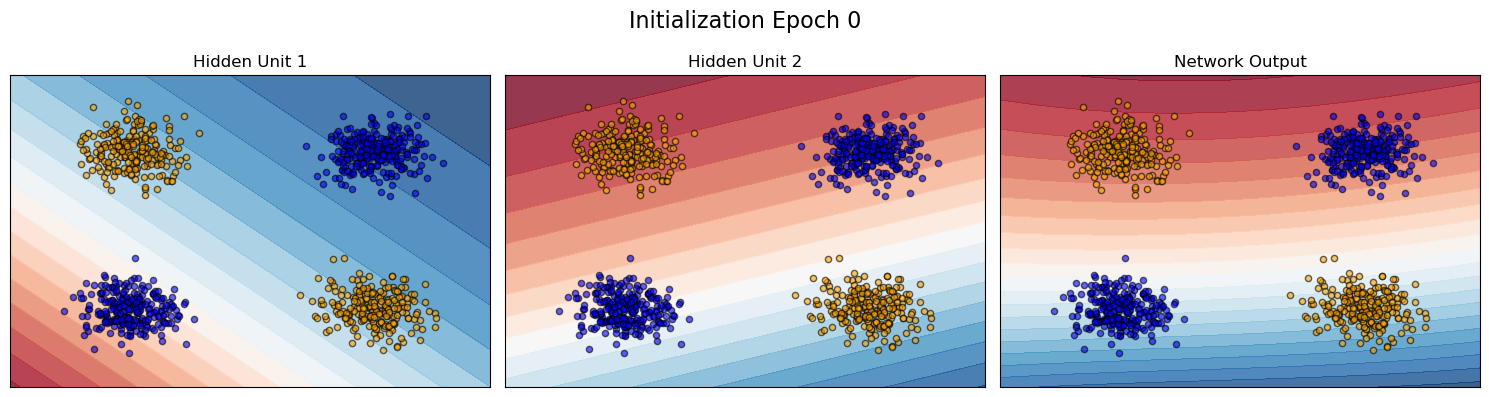

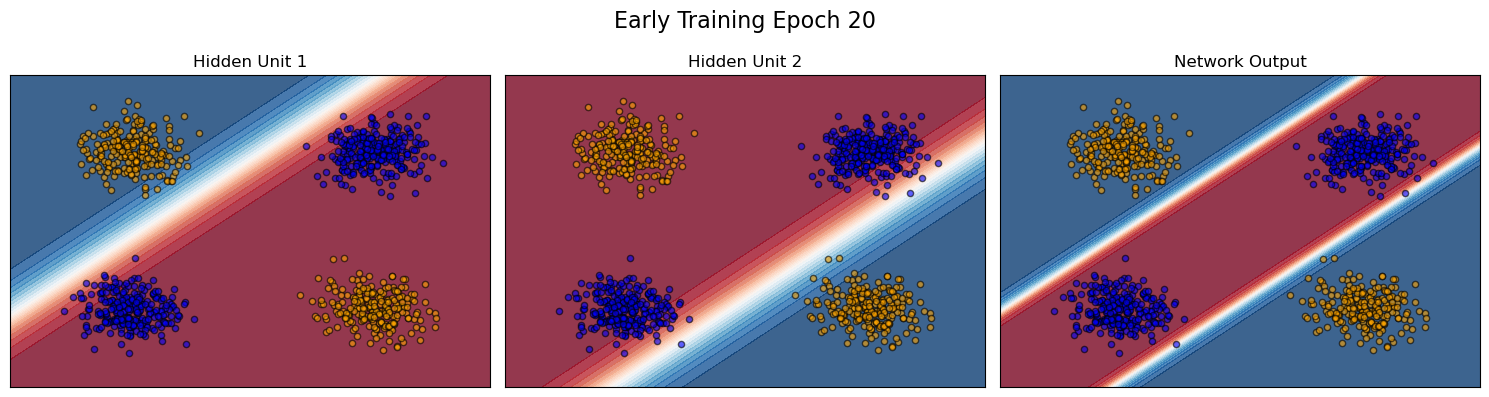

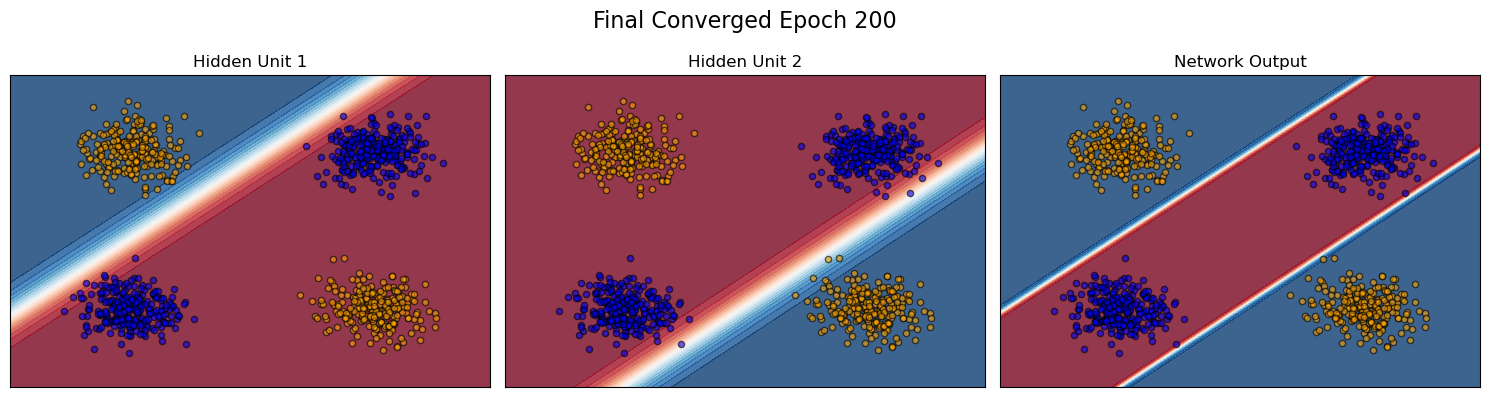

In [17]:
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 3 – Visualization Function (Replicating Sandbox)
# Theory Reference: XOR_NNsandbox.ipynb (Visualizing Hidden Units)
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
def plot_three_boundaries(state_dict, dataset, epoch_idx, title_prefix=""):

    """
    Goal: Visualize the "internal logic" of the network.
    Instead of just plotting the final output, we plot the decision boundary of 
    EVERY neuron (Hidden 1, Hidden 2, and Output) to see how they cooperate.
    
    Theory:
    - Hidden Units: These define linear hyperplanes (straight lines) in the input space.
    - Output Unit: This combines the non-linear activations of the hidden units.
    This visualization proves that the network solves XOR by decomposing it into 
    two linear problems (AND/OR logic) and combining them.
    """

    #Extract weights manually from the saved history state
    W1 = state_dict['hidden.weight'].numpy() # Shape (2, 2)
    b1 = state_dict['hidden.bias'].numpy()   # Shape (2,)
    W2 = state_dict['output.weight'].numpy() # Shape (1, 2)
    b2 = state_dict['output.bias'].numpy()   # Shape (1,)

    #Create a grid of points to visualize the decision surface
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid = np.c_[xx.ravel(), yy.ravel()]

    #Manual Forward Pass (using NumPy) to inspect intermediate values
    #Pre-activation of hidden layer: z = xW^T + b
    h_pre = grid @ W1.T + b1
    #Activation of hidden layer: h = tanh(z)
    h_act = np.tanh(h_pre)
    #Pre-activation of output layer: out = hW^T + b
    out_pre = h_act @ W2.T + b2
    #Final Probability: p = sigmoid(out)
    out_prob = 1 / (1 + np.exp(-out_pre))

    #Reshape data for plotting (3 separate plots)
    Z_h1 = h_act[:, 0].reshape(xx.shape) #Activation of Hidden Unit 1
    Z_h2 = h_act[:, 1].reshape(xx.shape) #Activation of Hidden Unit 2
    Z_out = out_prob.reshape(xx.shape)   #Final Output Probability
    
    Z_list = [Z_h1, Z_h2, Z_out]
    titles = ["Hidden Unit 1", "Hidden Unit 2", "Network Output"]

    #Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    plt.suptitle(f"{title_prefix} Epoch {epoch_idx}", fontsize=16)
    
    X_data = dataset.data.numpy()
    y_data = dataset.labels.numpy().flatten()

    for ax, Z, title in zip(axes, Z_list, titles):
        # Draw filled contours for the decision boundary
        ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu, levels=20)
        # Overlay actual data points
        ax.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], c='blue', edgecolors='k', s=20, alpha=0.6)
        ax.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], c='orange', edgecolors='k', s=20, alpha=0.6)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

#Generate Snapshots for Report
#We pick three key moments: start, middle, and end.
plot_three_boundaries(history[0], train_dataset, 0, "Initialization")
plot_three_boundaries(history[20], train_dataset, 20, "Early Training")
plot_three_boundaries(history[-1], train_dataset, 200, "Final Converged")

In [18]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 4 – Animation Generation
# Goal: Create a smooth video showing the "Evolution" of the boundaries.
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

#Setup figure for animation (prevent double display with plt.close)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plt.close() 

#Coarser grid for faster rendering in video
x_min, x_max, y_min, y_max = -0.5, 1.5, -0.5, 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
grid = np.c_[xx.ravel(), yy.ravel()]
X_data = train_dataset.data.numpy()
y_data = train_dataset.labels.numpy().flatten()

def animate(i):
    """Updates the plot for frame 'i' corresponding to epoch 'i'"""
    state = history[i]
    
    #Extract weights
    W1 = state['hidden.weight'].numpy()
    b1 = state['hidden.bias'].numpy()
    W2 = state['output.weight'].numpy()
    b2 = state['output.bias'].numpy()

    #Forward pass
    h_act = np.tanh(grid @ W1.T + b1)
    out_prob = 1 / (1 + np.exp(-(h_act @ W2.T + b2)))
    
    #List of surfaces to plot
    Z_list = [h_act[:, 0].reshape(xx.shape), h_act[:, 1].reshape(xx.shape), out_prob.reshape(xx.shape)]
    titles = ["Hidden 1", "Hidden 2", "Output"]

    #Update axes
    for j, ax in enumerate(axes):
        ax.clear() #Clear previous frame
        ax.contourf(xx, yy, Z_list[j], alpha=0.8, cmap=plt.cm.RdBu, levels=20)
        ax.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], c='blue', s=5, alpha=0.3)
        ax.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], c='orange', s=5, alpha=0.3)
        ax.set_title(titles[j])
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(f"Training Evolution - Epoch {i}", fontsize=14)

#Create Animation: Skip frames (step=2) to keep video short
frames = range(0, len(history), 2) 
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)

#Display as HTML5 video in Jupyter Notebook
HTML(anim.to_html5_video())

To investigate the learning dynamics of the minimal XOR network, we trained a model with a single hidden layer containing two units and Tanh activation functions. By capturing snapshots of the decision boundaries throughout the training process, we were able to visualize how the network progressively decomposes the non-linear problem into simpler linear tasks. At initialization (Epoch 0), the network's weights are random, resulting in arbitrary linear decision boundaries for both the hidden units and the final output that fail to capture the underlying structure of the data. As training proceeds to the early stages (Epoch 20), the optimization process begins to adjust the weights, causing the hidden units to rotate and shift their decision boundaries to isolate specific groups of data points, although the separation remains imperfect at this stage. By the final stage of convergence (Epoch 200), the network has successfully learned a solution where the two hidden units act as distinct feature detectors, each linearly separating a specific subset of the data clusters. The final output layer then combines these linear features to produce a non-linear decision boundary that effectively separates the XOR classes. This visualization confirms the theoretical understanding that a minimal network with just two hidden units possesses sufficient capacity to solve the XOR problem by transforming the input space into a representation where the classes become linearly separable.

## 4

### 4.1

Consider feedforwardAssignment.ipynb and choose a promising network configuration. Modify the notebook to log the training progress in the MLOps platform, and show the resulting plots in your report. Describe the modifications you made to use the MLOps platform and include code excerpts of the modifications in your report (should only be a few lines of code).

In [19]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [20]:
#—————————————————–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# First step – Setup MLOps Platform (Weights & Biases)
# Theory used: Fitting NNs Tricks of the Trade MLOps.pdf 
#—————————————————–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

#Goal: Initialize the experiment tracking system.
#Theory: MLOps combines ML, DevOps, and Data Engineering to maintain reliability.
#By tracking "runs", we create a reproducible log of exactly what code and hyperparameters produced a specific result, solving the "it worked on my machine" problem.

# Login to W&B (You will need your API key from wandb.ai)
wandb.login()

# Initialize the run
run = wandb.init(
    # Set the project name where this run will be logged
    project="noisy-xor-assignment",
    
    # Theory: Slide 832 "Tune". We log hyperparameters (config) so we can 
    # compare different runs later to see which settings (learning rate, width, etc.) 
    # resulted in the best model.
    config={
        "learning_rate": 0.01,
        "epochs": 100,
        "batch_size": 32,
        "architecture": "DynamicFeedForward",
        "depth": 2,  # Chosen based on Task 3.2 results
        "width": 3
    }
)

wandb: Currently logged in as: alberteplhansen (alberteplhansen-k-benhavns-universitet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
#—————————————————–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Step 2 – Setup Model & Data
# Theory used: DLBackpropagation.pdf
#—————————————————–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
#Goal: Instantiate the specific configuration we want to track.
#We use the hyperparameters saved in 'wandb.config' so the code always matches the logs.

model = DynamicFeedForward(depth=wandb.config.depth, width=wandb.config.width)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

#Goal: Monitor the internal state of the model during training.
#'wandb.watch' hooks into PyTorch to log the distribution of gradients and weights.
#Theory: This helps detect issues like "Vanishing Gradients" or dead neurons by visualizing if gradients go to zero.
wandb.watch(model, criterion, log="all", log_freq=10)

#Loaders (Assuming dataset is already created)
train_loader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=False)



In [22]:
#–––––––––––––—————————————————––––––––––––––––––––––––––––––––––––––––––––
# Step 3 – Training Loop with Real-time Logging
# Theory used: Fitting NNs Tricks of the Trade MLOps.pdf 
#–––––––––––––—————————————————––––––––––––––––––––––––––––––––––––––––––––
print("Starting training with W&B logging...")

for epoch in range(wandb.config.epochs):
    #Training Phase
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    #Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    
    #Validation Phase
    #Theory: "Always plot training and validation metrics in the same plot".
    #We calculate validation loss to check for overfitting (where train goes down, val goes up).
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    
    #THE MODIFICATION: Log metrics to W&B
    #Goal: Stream the calculated metrics to the dashboard.
    #This replaces the static matplotlib plots we made earlier with interactive, real-time charts that update as the model trains.
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}")

#Finish the run to upload final bits and close the connection
wandb.finish()

Starting training with W&B logging...
Epoch 10: Train Loss 0.0123, Val Loss 0.0096
Epoch 20: Train Loss 0.0022, Val Loss 0.0019
Epoch 30: Train Loss 0.0010, Val Loss 0.0009
Epoch 40: Train Loss 0.0006, Val Loss 0.0005
Epoch 50: Train Loss 0.0004, Val Loss 0.0003
Epoch 60: Train Loss 0.0003, Val Loss 0.0002
Epoch 70: Train Loss 0.0002, Val Loss 0.0002
Epoch 80: Train Loss 0.0001, Val Loss 0.0001
Epoch 90: Train Loss 0.0001, Val Loss 0.0001


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 100: Train Loss 0.0001, Val Loss 0.0001


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,9e-05
val_loss,8e-05


## 4.2

Implement a hyperparameter sweep using an MLOps platform, e.g., a W&B sweep. Sweep over the parameters you find most important (but keep the sweep of a size compatible with the compute resources you have - the size of the sweep will not affect the grading). Visualize the results using, e.g., a parallel coordinate plot in W&B.

In [23]:
#–––––––––––––––––––––––––––––––––––––––––––––
# Step 1 – Define the Sweep Configuration
#–––––––––––––––––––––––––––––––––––––––––––––
sweep_config = {
    'method': 'grid',  #We want to try EVERY combination (Grid Search)
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'   
    },
    'parameters': {
        'depth': {
            'values': [0, 1, 2, 3]
        },
        'width': {
            'values': [1, 2, 3]
        },
        'learning_rate': {
            'values': [0.01, 0.001] #Testing two different rates as requested
        },
        'epochs': {
            'value': 100
        },
        'batch_size': {
            'value': 32
        }
    }
}

#Initialize the sweep on the W&B server
sweep_id = wandb.sweep(sweep_config, project="noisy-xor-assignment")

Create sweep with ID: 5l7e0saz
Sweep URL: https://wandb.ai/alberteplhansen-k-benhavns-universitet/noisy-xor-assignment/sweeps/5l7e0saz


In [24]:
#–––––––––––––––––––––––––––––––––––––––––––––
# Step 2 – Define the Training Function
#–––––––––––––––––––––––––––––––––––––––––––––
def train_sweep():
    #Initialize a new run
    #W&B automatically passes the specific parameters for this run into `wandb.config`
    with wandb.init() as run:
        config = wandb.config
        
        #Setup Data (Re-using existing datasets)
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
        
        #Setup Model (Using dynamic params from config)
        model = DynamicFeedForward(depth=config.depth, width=config.width)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        
        #Training Loop
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            
            #Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            
            #Log metrics
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss
            })

In [25]:
#–––––––––––––––––––––––––––––––––––––––––––––
# Step 3 – Start the Sweep Agent
#–––––––––––––––––––––––––––––––––––––––––––––
print("Starting Sweep... this will run 24 experiments!")
wandb.agent(sweep_id, function=train_sweep)

Starting Sweep... this will run 24 experiments!


wandb: Agent Starting Run: 0qnoofvd with config:
wandb: 	batch_size: 32
wandb: 	depth: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss,█▇▄▃▂▂▂▃▁▂▂▁▁▂▂▃▂▂▂▄▃▂▂▁▂▂▁▁▃▂▁▃▃▁▁▁▃▂▁▂
val_loss,█▅▂▂▂▁▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▂▂▁▂▁▂▂
epoch,99
train_loss,0.69078
val_loss,0.69208


wandb: Agent Starting Run: p8m4wmk8 with config:
wandb: 	batch_size: 32
wandb: 	depth: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,▆▄▇▆▅▄▄▅▆▄▇█▆▄▄▆▅▅▇▁▅▆▆▅▄▅▅▃▃▄▅▄▆▃▅▄▅▅▇▅
val_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.69091
val_loss,0.69223


wandb: Agent Starting Run: zb3to8gr with config:
wandb: 	batch_size: 32
wandb: 	depth: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▄▃▃▄▃▂▃▂▂▂▂▃▂▃▃▂▃▁▂▂▂▂▂▂▂▃▃▂▂▃▂▃▃▁▂▂▃▂▃
val_loss,▇▇█▄▇▂▂▂▃▃▃▄▂▂▂▂▁▃█▄▂▂▂▃▃▃▂▃▂▄▂▂▃▃▁▃▁▁▅▁
epoch,99
train_loss,0.69127
val_loss,0.6917


wandb: Agent Starting Run: 216bj2qs with config:
wandb: 	batch_size: 32
wandb: 	depth: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▇█▆▆▅▅▆▅▄▄▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁▁
val_loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.69007
val_loss,0.69229


wandb: Agent Starting Run: hjwss64o with config:
wandb: 	batch_size: 32
wandb: 	depth: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss,█▇▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.6894
val_loss,0.69269


wandb: Agent Starting Run: 9c3nejhf with config:
wandb: 	batch_size: 32
wandb: 	depth: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.69041
val_loss,0.69194


wandb: Agent Starting Run: ieajgkaq with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▆▆▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.48021
val_loss,0.49199


wandb: Agent Starting Run: 6kdv5xcn with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,████▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.34251
val_loss,0.34852


wandb: Agent Starting Run: 6la54wih with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
train_loss,██▇▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.00196
val_loss,0.00173


wandb: Agent Starting Run: km4vzmnx with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,███▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,99
train_loss,0.53774
val_loss,0.53482


wandb: Agent Starting Run: 0ugr16mn with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss,██████████████████▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▂▂▂▁
val_loss,█████████████████▇▇▇▇▇▇▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁
epoch,99
train_loss,0.37117
val_loss,0.36761


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h1hx8td5 with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss,██████████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_loss,██████████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
epoch,99
train_loss,0.18804
val_loss,0.18445


wandb: Agent Starting Run: az9r2brg with config:
wandb: 	batch_size: 32
wandb: 	depth: 2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train_loss,███▇▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.47373
val_loss,0.47418


wandb: Agent Starting Run: 0afefgv7 with config:
wandb: 	batch_size: 32
wandb: 	depth: 2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.35974
val_loss,0.34737


wandb: Agent Starting Run: wkvr1izn with config:
wandb: 	batch_size: 32
wandb: 	depth: 2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.00023
val_loss,0.00019


wandb: Agent Starting Run: z1gb3wl4 with config:
wandb: 	batch_size: 32
wandb: 	depth: 2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
train_loss,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▇▆▆▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.49532
val_loss,0.49697


wandb: Agent Starting Run: 2xqahhux with config:
wandb: 	batch_size: 32
wandb: 	depth: 2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
train_loss,█████████████████▇▇▇▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,███████████████████▇▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.03487
val_loss,0.03111


wandb: Agent Starting Run: wkc8mqs7 with config:
wandb: 	batch_size: 32
wandb: 	depth: 2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█████████▇▇▇▆▆▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██████████████▇▆▆▆▅▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.01062
val_loss,0.00955


wandb: Agent Starting Run: bx618zrw with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▆▃▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.47442
val_loss,0.47398


wandb: Agent Starting Run: db5151cp with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇█████
train_loss,█▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.00023
val_loss,0.00022


wandb: Agent Starting Run: k4sw0833 with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.00025
val_loss,0.00021


wandb: Agent Starting Run: do8pdezx with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 1


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,███▇▇▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.50641
val_loss,0.49703


wandb: Agent Starting Run: xx7qemid with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 2


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss,███████████▇▇▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,██████████████▇▅▄▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.05508
val_loss,0.05335


wandb: Agent Starting Run: 6u7bv53v with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	width: 3


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,███▇▇▇▇▇▆▆▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▇▇▇▆▆▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.01402
val_loss,0.01341


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
